# Hierarchical regression to house price prediction

This analysis is to predict house prices based on the house condition information at the time of sale. To raise the accuracy of the prediction, it performs hierarchical regression model.

# Package

In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statistics
import math
import random
import statsmodels.api as sm

from numpy.linalg import inv
from scipy.linalg import cholesky
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from itertools import chain

# Training data

In [254]:
train = pd.read_csv("train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Predictors

The following variables show nice correlation with house price (SalePrice), so we choose them as the predictors of regression.
<br>
OverallQual: Overall material and finish quality
<br>
YearBuilt: Original construction date
<br>
GrLivArea: Above grade (ground) living area square feet
<br>
GarageCars: Size of garage in car capacity

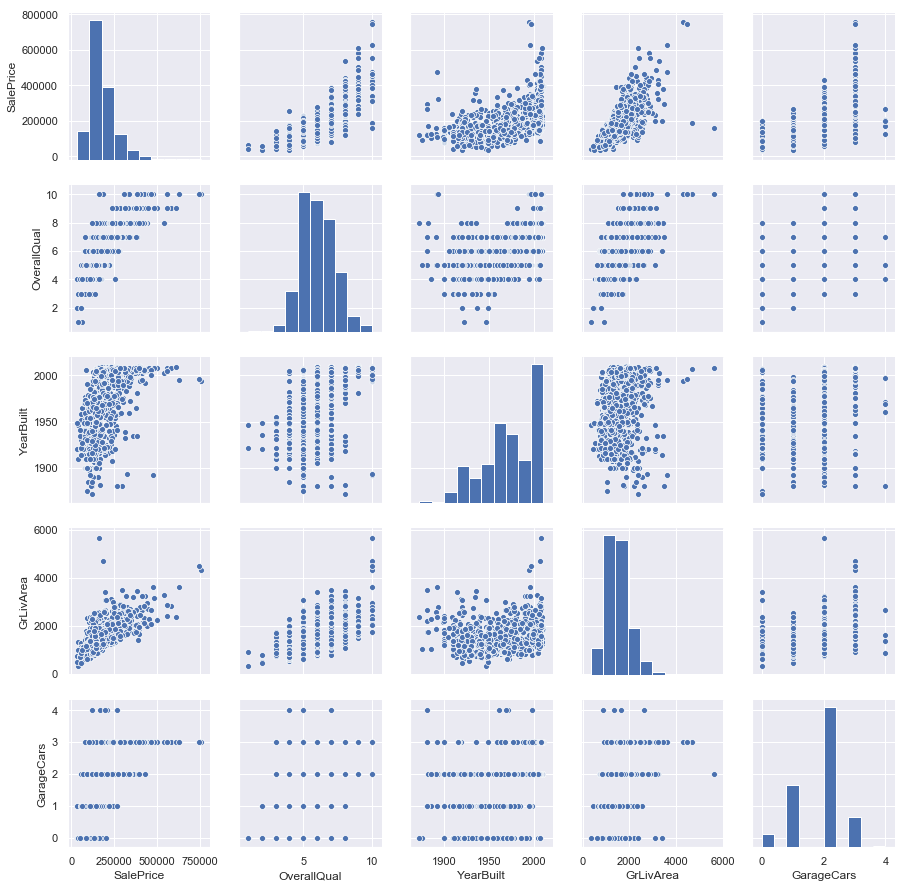

In [255]:
sns.set()
COLUMNS = ['SalePrice', 'OverallQual', 'YearBuilt', 'GrLivArea', 'GarageCars']
_ = sns.pairplot(train[COLUMNS])
plt.show()

# Hierarchy

The variable "Neighborhood" contains house location information. We assume that house price differs by locations and each location has different association between house price and predictios. So we set hierarchy by location (Neighborhood) in regression model.

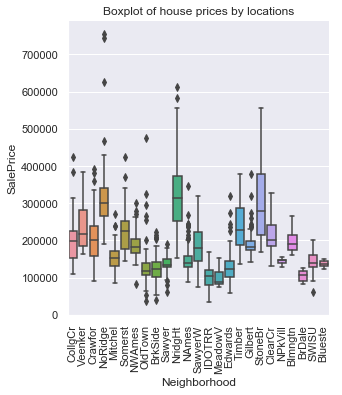

In [256]:
_ = sns.catplot(x = 'Neighborhood', y = 'SalePrice', kind = 'box', data = train)
_ = plt.xticks(rotation = 90)
_ = plt.title('Boxplot of house prices by locations')
plt.show()

# Model data development

Make predictor dataset. Apply centering to each predictor by deducting mean. It is the mean in each group, so centering is conducted within each location. Parameters are estimated by locations, so we make list of predictors and response.

In [257]:
X_COLUMNS = ['OverallQual', 'YearBuilt', 'GrLivArea', 'GarageCars']

# preprocessing scale function shows warning if data type is int64
temp_df = train[X_COLUMNS].astype(np.float64)

Neighborhood_list = np.unique(train['Neighborhood'])
m = len(Neighborhood_list)
X_list = []

for i in np.arange(0,m,1):
    temp = temp_df.loc[train['Neighborhood'] == Neighborhood_list[i]]
    # centering, not scaling
    temp = preprocessing.scale(temp.values,
                               with_mean = True,
                               with_std = False)
    # adding intercept. do this after centering, otherwise intercept will be 0
    temp = sm.add_constant(temp)
    X_list.append(temp)
    
X = X_list

Similarly, make response dataset (y)

In [258]:
temp_df = train['SalePrice']
y_list = []

for i in np.arange(0, len(Neighborhood_list),1):
    y_list.append(temp_df.loc[train['Neighborhood'] == Neighborhood_list[i]])
    
y = y_list

# Functions for Markov chain Monte Carlo (MCMC)

We conduct Bayesian approach to randomly sample parameters from distribution in the Markov chain Monte Carlo (MCMC). To achieve this, we define random sampling function.

In [259]:
def rmvnorm(n, mu, Sigma):
    E = np.random.normal(0, 1, n*len(mu))
    return np.dot(E, cholesky(Sigma, lower = False)) + mu

In [260]:
def rwish(nu0, S0):
    sS0 = cholesky(S0, lower = False)
    Z = np.dot(np.random.normal(0, 1, rwish_mean*rwish_var.shape[0]).reshape(rwish_mean, rwish_var.shape[0]), sS0)
    S = np.dot(np.transpose(Z), Z)
    return S

# Prior values

For priors in a hierarchical regression, estimate regression parameters in each hirarchy. The within-group sample variance is the square root of the residual sum of square divided by degree of freedom. Warning is, a group has little data, and can't estimate regression model. Need to resolve 0 coefficients for beta, and inf variance.

In [261]:
m = len(Neighborhood_list)
p = X[0].shape[1]
BETA_LS = np.zeros([m, p])
S2_LS = np.zeros(m)

for i in np.arange(0,m,1):
    
    # fit OLS to each group
    results = sm.OLS(y[i], X[i]).fit()
    
    # calculate parameters
    beta = results.params
    
    # calculate sample variance
    RSS = sum(results.resid ** 2)
    df = results.df_resid
    sample_variance = RSS/df
    
    # store outputs
    BETA_LS[i] = beta
    S2_LS[i] = sample_variance  

C:\Users\yukic\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [262]:
p = X[0].shape[1]
theta = pd.DataFrame(BETA_LS).apply(statistics.mean, axis = 0)
mu0 = pd.DataFrame(BETA_LS).apply(statistics.mean, axis = 0)
nu0 = 1
s2 = statistics.mean(S2_LS[np.isfinite(S2_LS)])
s20 = statistics.mean(S2_LS[np.isfinite(S2_LS)])
eta0 = p + 2
Sigma = np.cov(BETA_LS, rowvar = False)
S0 = np.cov(BETA_LS, rowvar = False)
L0 = np.cov(BETA_LS, rowvar = False)
BETA = BETA_LS
iL0 = inv(L0)
iSigma = inv(Sigma)

N = np.zeros(m)
for i in np.arange(0,m,1):
    N[i] = len(X[i])

Setup for MCMC sampling.

In [263]:
# MCMC setting and storing
random.seed(0)
S = 5000
S2_b = np.zeros(S)
THETA_b = np.zeros([S, p])
Sigma_ps = np.zeros([p, p])
BETA_ps = BETA * 0
SIGMA_PS = np.zeros([S, p * p])
BETA_pp = np.zeros([S, p])

# Likelihood and Posterior values (MCMC part)

In [264]:
for s in np.arange(0,S,1):

    # update beta_j
    for j in np.arange(0,m,1):
        Vj = inv(iSigma + np.dot(np.transpose(X[j]), X[j])/s2)
        Ej = np.dot(Vj, np.dot(iSigma, theta) + np.dot(np.transpose(X[j]), y[j])/s2)
        BETA[j] = rmvnorm(1, Ej, Vj)

    # update theta
    Lm = inv(iL0 + m * iSigma)
    mum = np.dot(Lm, np.dot(iL0, mu0) + np.dot(iSigma, pd.DataFrame(BETA).apply(sum, axis = 0)))
    theta = rmvnorm(1, mum, Lm)

    # update Sigma
    rwish_mean = eta0 + m
    rwish_var = inv(S0 + np.dot(np.transpose(BETA - theta), BETA - theta))
    iSigma = rwish(rwish_mean, rwish_var)

    # update s2
    RSS = 0
    for j in np.arange(0,m,1):
        RSS = RSS + sum((y[j] - np.dot(X[j], BETA[j])) ** 2)
    s2 = 1/np.random.gamma(shape = (nu0 + sum(N))/2, scale = 1/((nu0*s20+RSS)/2), size = 1)

    # store results
    S2_b[s] = s2
    THETA_b[s] = theta
    Sigma_ps = Sigma_ps + inv(iSigma)
    BETA_ps = BETA_ps + BETA
    SIGMA_PS[s] = np.matrix.flatten(inv(iSigma))
    BETA_pp[s] = rmvnorm(1, theta, inv(iSigma))

# MCMC sampling check

Check the distribution of estimated values. In prediction, we will use the expected values of these distributions.

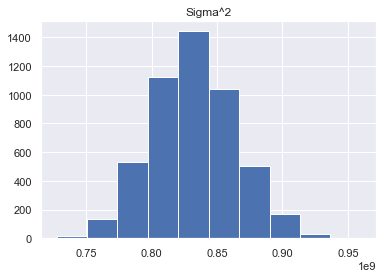

In [265]:
_ = plt.hist(S2_b)
_ = plt.title("Sigma^2")
plt.show()

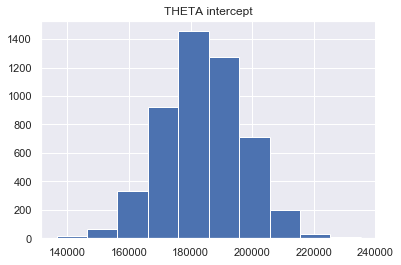

In [266]:
_ = plt.hist(THETA_b[:,0])
_ = plt.title("THETA intercept")
plt.show()

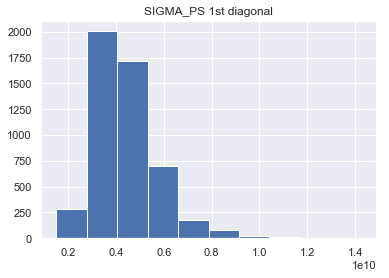

In [267]:
_ = plt.hist(SIGMA_PS[:,0])
_ = plt.title("SIGMA_PS 1st diagonal")
plt.show()

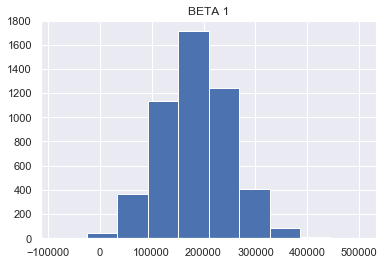

In [268]:
_ = plt.hist(BETA_pp[:,0])
_ = plt.title("BETA 1")
plt.show()

# Training accuracy

Calculate training accuracy Mean Squared Prediction Error (MSPE). we will compare the accuracy by ordinary least squared regression and this approach, and confirm the nice effect of hierarchical regression. First, we check the estimated predictor coefficients. By hierarchical regression, we have different estimated predictor coefficients by location.

In [269]:
neighborhood_list_df = pd.DataFrame(Neighborhood_list,
                                    columns = ['Neighborhood'])
coef = pd.DataFrame(BETA_ps/S)
coef = pd.concat([neighborhood_list_df, coef], 
                 axis = 1)
coef.rename(columns = {0:'Intercept_coef',
                       1:'OverallQual_coef',
                       2:'YearBuilt_coef',
                       3:'GrLivArea_coef',
                       4:'GarageCars_coef'},
            inplace = True)
round(coef)

,Neighborhood,Intercept_coef,OverallQual_coef,YearBuilt_coef,GrLivArea_coef,GarageCars_coef
0,Blmngtn,195034.0,20717.0,591.0,64.0,13698.0
1,Blueste,142508.0,12842.0,82.0,40.0,12768.0
2,BrDale,105566.0,7141.0,-517.0,27.0,11869.0
3,BrkSide,125830.0,11042.0,-18.0,45.0,12183.0
4,ClearCr,211194.0,20810.0,148.0,58.0,22047.0
5,CollgCr,197642.0,16413.0,-276.0,64.0,19831.0
6,Crawfor,210003.0,23373.0,890.0,62.0,7640.0
7,Edwards,127565.0,8315.0,241.0,14.0,13098.0
8,Gilbert,192667.0,16066.0,292.0,60.0,25633.0
9,IDOTRR,102423.0,11212.0,28.0,32.0,7805.0


Develop data to calculate MSPE in the training dataset.

In [270]:
temp_y = np.matrix(y[0]).transpose()
temp_x = np.matrix(X[0])
temp_yx = pd.DataFrame(np.concatenate((temp_y, temp_x), axis = 1))
temp_yx['Neighborhood'] = Neighborhood_list[0]

m = len(Neighborhood_list)

for i in range(1, m):
    temp_y = np.matrix(y[i]).transpose()
    temp_x = np.matrix(X[i])
    temp = pd.DataFrame(np.concatenate((temp_y, temp_x), axis = 1))
    temp['Neighborhood'] = Neighborhood_list[i]
    temp_yx = pd.concat([temp_yx, temp], axis = 0)
    
temp_yx.rename(columns = {0:'SalePrice',
                          1:'Intercept',
                          2:'OverallQual',
                          3:'YearBuilt',
                          4:'GrLivArea',
                          5:'GarageCars'},
               inplace = True)

train_pred_df = temp_yx.merge(coef, on = 'Neighborhood', how = 'left')

Calculate estimated SalePrice by using estimated coefficients.

In [271]:
train_pred_df['SalePrice_pred_BDA'] = (
    train_pred_df['Intercept'] * train_pred_df['Intercept_coef']
    + train_pred_df['OverallQual'] * train_pred_df['OverallQual_coef']
    + train_pred_df['YearBuilt'] * train_pred_df['YearBuilt_coef']
    + train_pred_df['GrLivArea'] * train_pred_df['GrLivArea_coef']
    + train_pred_df['GarageCars'] * train_pred_df['GarageCars_coef']
)

# print(train_pred_df[['SalePrice', 'SalePrice_pred_BDA']].head().round())

MSPE_train_BDA = statistics.mean((train_pred_df['SalePrice'] - train_pred_df['SalePrice_pred_BDA'])**2)
print('MSPE in training dataset by hierarchical regression {:,}'.format(round(MSPE_train_BDA)))

MSPE in training dataset by hierarchical regression 788,527,119


# Predicted values from OLS regression

In [272]:
train = pd.read_csv("train.csv")
y = train['SalePrice'].values
COLUMNS = ['OverallQual', 'YearBuilt', 'GrLivArea', 'GarageCars']
X = train[COLUMNS].values
model = LinearRegression()
model.fit(X, y)
train_pred = model.predict(X)
train = pd.concat([train['SalePrice'], pd.DataFrame(train_pred)], axis = 1)
train.rename(columns = {0:'SalePrice_pred_OLS'},
                inplace = True)
train.round().head()

,SalePrice,SalePrice_pred_OLS
0,208500,227877.0
1,181500,169809.0
2,223500,231440.0
3,140000,212301.0
4,250000,293382.0


In [273]:
MSPE_train_OLS = statistics.mean((train['SalePrice'] - train['SalePrice_pred_OLS'])**2)
print('MSPE in training dataset by OLS regression {:,}'.format(round(MSPE_train_OLS)))

MSPE in training dataset by OLS regression 1,577,115,307


Both approaches has the same number of predictios, but hierarchical regression allows us to estimate by different locations, resulting is lower MSPE.

# Prediction in test dataset

# Test data

Test data does not contrain actual house price.

In [274]:
test = pd.read_csv("test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [275]:
test.shape

(1459, 80)

# Imputation missing values in test data

In [276]:
COLUMNS = ['Id', 'OverallQual', 'YearBuilt', 'GrLivArea', 'GarageCars', 'Neighborhood']
X_test = test[COLUMNS]
print(X_test.shape)
print(X_test.isnull().sum())

(1459, 6)
Id              0
OverallQual     0
YearBuilt       0
GrLivArea       0
GarageCars      1
Neighborhood    0
dtype: int64


In [277]:
# imputing missing values
COLUMNS = ['GarageCars']
test_temp = test[COLUMNS]
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
test_temp = imp_mean.fit_transform(test_temp)
test_temp = pd.DataFrame(test_temp, columns = COLUMNS)
print(test_temp.shape)
print(test_temp.isnull().sum())

(1459, 1)
GarageCars    0
dtype: int64


In [278]:
COLUMNS = ['Id', 'OverallQual', 'YearBuilt', 'GrLivArea', 'Neighborhood']
X_test = X_test[COLUMNS]
X_test = pd.concat([X_test, test_temp], axis = 1)

# Develop data to predict in test dataset

When we built train dataset for MCMC, we scaled predictors, ie deducted predictor values by means of each predictor. So we need to deduct test predictor values also.

In [279]:
train = pd.read_csv("train.csv")
PREDICTORS = ['OverallQual', 'YearBuilt', 'GrLivArea', 'GarageCars']
NEWCOLUMNS = ['OverallQual_scaled', 'YearBuilt_scaled', 'GrLivArea_scaled', 'GarageCars_scaled']

for var, new in zip(PREDICTORS, NEWCOLUMNS):
    
    mean = train.groupby('Neighborhood')[var].mean()
    mean_df = pd.DataFrame(data = {'Neighborhood':mean.index, 'mean':mean.values})
    X_test = pd.merge(left = X_test, right = mean_df, on = 'Neighborhood', how = 'left')
    X_test[new] = X_test[var] - X_test['mean']
    X_test = X_test.drop(columns = ['mean'])
    
X_test = pd.merge(left = X_test, right = coef, on = 'Neighborhood', how = 'left')

Predict house prices.

In [280]:
X_test['SalePrice'] = (
    X_test['Intercept_coef']
    + X_test['OverallQual_scaled'] * X_test['OverallQual_coef']
    + X_test['YearBuilt_scaled'] * X_test['YearBuilt_coef']
    + X_test['GrLivArea_scaled'] * X_test['GrLivArea_coef']
    + X_test['GarageCars_scaled'] * X_test['GarageCars_coef']
)
X_test['SalePrice'].describe()

count      1459.000000
mean     179618.367898
std       75477.918897
min       25592.588701
25%      128486.073383
50%      158296.854841
75%      211368.626100
max      565835.045949
Name: SalePrice, dtype: float64

# Export prediction

In [315]:
sub = X_test[['Id', 'SalePrice']]

In [316]:
# sub.to_csv('C:\\Users\\yukic\\Documents\\kaggle\\houseprices\\submission_190704.csv', index = False)